In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200
import matplotlib.colors as colors
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy.linalg as la
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import StepLR
from pathlib import Path

### **BCI Data Processing**

dt_si: time step in seconds

iscell: 1 if cell is neuron, else 0

dat_file: name of file

session: date of session

mouse: name of mouse

mean_image: session mean image of the FOV

fov: name of field of view

dprime_1dFperF: the d-prime of each ROI for a 100% dF/F change

version: version of this data format

spont: (dictionary)
- Ftrace: raw fluorescence
- trace_corr: correlations of spontaneous activity

BCI_1: (dictionary) first BCI task of day, BCI_2, BCI_3, etc.....
- F: deltaF/F during behavior
- Fraw: raw flueorescence intensity during behavior
- df_closedloop: dF/F0 during behavior (F0 is numpy.std(Fraw))
- centroidX: mean X pixel indices for each neuron
- centroidY: mean Y pixel indices for each neuron
- Ftrace: raw fluorescence
- trace_corr: correlations of activity
- dist: distance from conditioned neuron in pixels
- conditioned_neuron_coordinates: location of CN in pixels (X,Y)
- conditioned_neuron: index of conditioned neuron
- reward_time: time of rewards
- step_time: time of lickport steps
- Trial_start: time of trial starts
- lick_time: time of licks
- threshold_crossing_time: time of threshold crossing

photostim: (dictionary)
- FstimRaw: (neurons x time) raw fluorescence intensity during photostimulation
- Fstim: (time x neurons x photostimulation trials) dF/F0 of photostim experiments where F0 i sthe avg F before stimulation
- seq: (array of int) photostimulation group IDs
- favg: (time x neurons x photostim groups) avg response to photostimulation 
- stimDist: (neurons x photostim groups) distance of each cell from closest photostimulation beamlet in pixels
- stimPosition: (beamlet x 2 x photostim groups) XY coordinates of each photostim beamlet in each photostim group
- centroidX: (list of neurons) mean X pixel indices for each neuron
- centroidY: (list of neurons) mean Y pixel indices for each neuron
- slmDist: (neurons x photostim groups) distance of each neuron from each center of the SLM in pixels
- stimID: (array of int time) all 0s except at onset of photostimulations, where its value is photostim group index

In [2]:
mpl.rcParams['figure.dpi'] = 300 #set resolution of matplots to 300DPI (dots per inch)

date = '070623'
mouse = '59'

%cd "C:\Users\andre\Desktop\active_neuron"

# keys of the np array dictionary
data_all = np.load('data/BCI_' + mouse + '-' + date + '.npy', allow_pickle = True).item()
data_all.keys()

C:\Users\andre\Desktop\active_neuron


dict_keys(['dt_si', 'iscell', 'dat_file', 'session', 'mouse', 'mean_image', 'fov', 'dprime_1dFperF', 'version', 'spont', 'BCI_1', 'BCI_2', 'photostim'])

In [3]:
data = []
dataset_id = 0
data.append(data_all['photostim']) #This is a dictionary

# keys of each photostim
print(data[dataset_id].keys())
print(" ")
print(f"FstimRaw: {data_all['photostim']['FstimRaw'].shape} (neurons, time) raw fluorescence intensity during photostimulation")
print(f"Fstim: {data_all['photostim']['Fstim'].shape} (time, neurons, photostim trials) dF/F0 of photostim experiments where F0 i sthe avg F before stimulation")
print(f"seq: {len(data_all['photostim']['seq'])} array of int photostimulation trials")
print(f"favg: {data_all['photostim']['favg'].shape} (time, neurons, photostim groups) avg response to photostimulation")
print(f"stimDist: {data_all['photostim']['stimDist'].shape}  (neurons x photostim groups) distance of each cell from closest photostimulation beamlet in pixels")
print(f"stimPosition: {data_all['photostim']['stimPosition'].shape} (beamlet x 2 x photostim groups) XY coordinates of each photostim beamlet in each photostim group")
print(f"centroidX: {len(data_all['photostim']['centroidX'])} (list of neurons) mean X pixel indices for each neuron")
print(f"centroidY: {len(data_all['photostim']['centroidY'])} (list of neurons) mean Y pixel indices for each neuron")
print(f"slmDist: {data_all['photostim']['slmDist'].shape} (neurons x photostim groups) distance of each neuron from each center of the SLM in pixels")
print(f"stimID: {len(data_all['photostim']['stimID'])} (array of int time) all 0s except at onset of photostimulations, where its value is photostim group index")
print(f"{len(data_all['photostim']['siHeader'])} ")
#print(data_all['photostim'])


dict_keys(['FstimRaw', 'Fstim', 'seq', 'favg', 'stimDist', 'stimPosition', 'centroidX', 'centroidY', 'slmDist', 'stimID', 'siHeader'])
 
FstimRaw: (502, 29308) (neurons, time) raw fluorescence intensity during photostimulation
Fstim: (25, 502, 2046) (time, neurons, photostim trials) dF/F0 of photostim experiments where F0 i sthe avg F before stimulation
seq: 2046 array of int photostimulation trials
favg: (25, 502, 100) (time, neurons, photostim groups) avg response to photostimulation
stimDist: (502, 100)  (neurons x photostim groups) distance of each cell from closest photostimulation beamlet in pixels
stimPosition: (10, 2, 100) (beamlet x 2 x photostim groups) XY coordinates of each photostim beamlet in each photostim group
centroidX: 502 (list of neurons) mean X pixel indices for each neuron
centroidY: 502 (list of neurons) mean Y pixel indices for each neuron
slmDist: (502, 100) (neurons x photostim groups) distance of each neuron from each center of the SLM in pixels
stimID: 2930

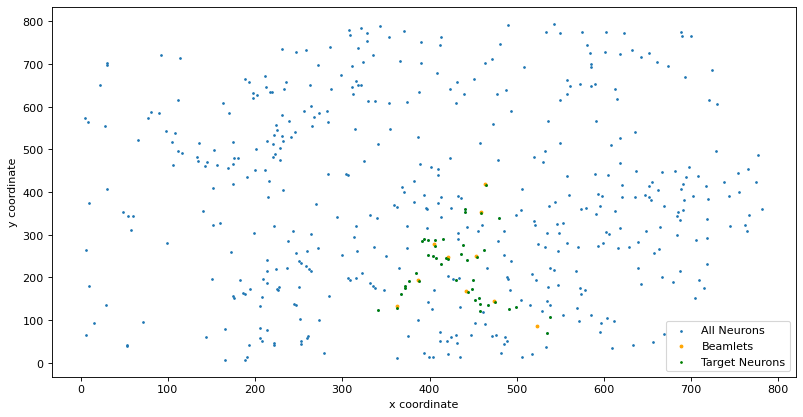

In [4]:
seq = data[dataset_id]['seq']
stimDist = data[dataset_id]['stimDist']

stim_group_id = 0
#neurons with distance to stimulation laser of less than 50 in photostim group 0
close_perturbation_center_neuron_ids = data_all['photostim']['slmDist'][:,stim_group_id] < 50
#indices of neurons with a distance to stimulation target of less than 30 in photostim group 0
target_neuron_ids = np.where(data_all['photostim']['stimDist'][:,stim_group_id] < 30)[0]

#all neurons
plt.figure(figsize=(12, 6), dpi=80)

plt.scatter(data_all['photostim']['centroidX'], data_all['photostim']['centroidY'], s = 2, label = "All Neurons")

#orange is the stimulation points, coordinates of the 10 photostim beamlets for photostim group 0
plt.scatter(data[dataset_id]['stimPosition'][:,0,stim_group_id], data[dataset_id]['stimPosition'][:,1,stim_group_id], s = 6, alpha = 1.0, color = 'orange', label = 'Beamlets')

#target neurons with distance of <30 from earlier
plt.scatter(np.asarray(data_all['photostim']['centroidX'])[target_neuron_ids], np.asarray(data_all['photostim']['centroidY'])[target_neuron_ids], color = 'green', s = 2, label = 'Target Neurons')

plt.xlabel('x coordinate')
plt.ylabel('y coordinate')

plt.legend()
plt.show()

In [5]:
#first 100 stimulation points data
print("all 0s except, except when photostimulated then the index is the photostim group id")
print(data[dataset_id]['stimID'][:50])

stimID = (data[dataset_id]['stimID'])
np.where(stimID != 0)

all 0s except, except when photostimulated then the index is the photostim group id
[ 0. 74.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 84.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 62.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. 13.  0.  0.  0.  0.  0.]


(array([    1,    15,    30, ..., 29217, 29231, 29246], dtype=int64),)

In [6]:
len(np.mean(data[dataset_id]['FstimRaw'],axis=0))

29308

In [7]:
stimID_correct = (data[dataset_id]['stimID']).copy()
stimID_correct[:50]

array([ 0., 74.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., 84.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., 62.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., 13.,  0.,  0.,  0.,  0.,  0.])

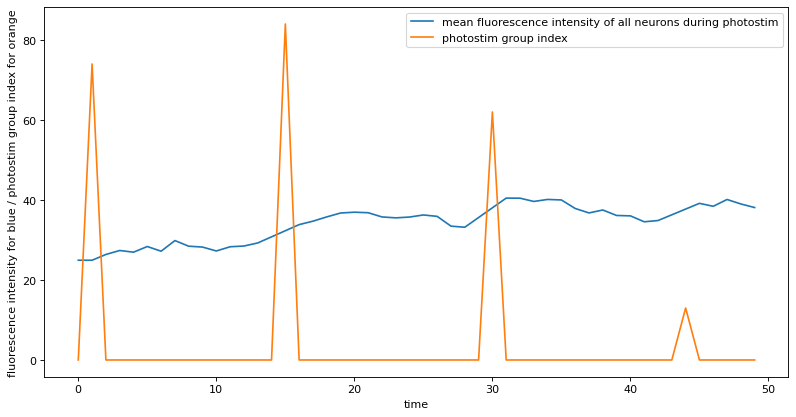

In [8]:
### padding zero right end to correct the shift
#all element except last one = all element except first one
# stimID_correct[:-1] = data[dataset_id]['stimID'][1:]


plt.figure(figsize=(12, 6), dpi=80)
#compare plots of mean of first 50 elements of 'FstimRaw' this is blue
plt.plot(np.mean(data[dataset_id]['FstimRaw'],axis=0)[:50], label='mean fluorescence intensity of all neurons during photostim')

plt.xlabel("time")
plt.ylabel("fluorescence intensity for blue / photostim group index for orange")

#orange plot of stimulation data
plt.plot(stimID_correct[:50], label='photostim group index')         
plt.legend()  

In [24]:
num_trials = np.where(stimID_correct != 0)[0].shape[0]
print(f"{num_trials} stimulus events out of {len(stimID_correct)} total time")

num_neurons = data[dataset_id]['FstimRaw'].shape[0] #502

Fstim_interp = data[dataset_id]['FstimRaw'].copy()

Fstim_baseline_mean = np.mean(Fstim_interp, axis = 1)
print(f"{len(Fstim_baseline_mean)} Fstim_baseline_mean is the mean of 29308 time readings for each of the 502 neurons")

Fstim_baseline_std = np.std(Fstim_interp, axis = 1)
print(f"{len(Fstim_baseline_std)} Fstim_baseline_std is the standard deviation of 29308 time readings for each of the 502 neurons")

Fstim_interp_norm = Fstim_interp
stim_steps = np.where(stimID_correct != 0)[0] #have to [0] just because there is 1 array within the np.array
print(f"{len(stim_steps)} stim_steps out of {len(stimID_correct)} total time steps, each step is an index like 0, 14, 29, .... 29216, 29230, 29245 where a stimulus happened")
print(f"{stim_steps.shape} stim_steps is 2046 steps of each t index where a stimulus happened")

print(f"{stimID_correct} stimID_correct is 0 at all t's except when there's a stimulus, there it's marked with the photostim group id")

2046 stimulus events out of 29308 total time
502 Fstim_baseline_mean is the mean of 29308 time readings for each of the 502 neurons
502 Fstim_baseline_std is the standard deviation of 29308 time readings for each of the 502 neurons
2046 stim_steps out of 29308 total time steps, each step is an index like 0, 14, 29, .... 29216, 29230, 29245 where a stimulus happened
(2046,) stim_steps is 2046 steps of each t index where a stimulus happened
[ 0. 74.  0. ...  0.  0.  0.] stimID_correct is 0 at all t's except when there's a stimulus, there it's marked with the photostim group id


In [10]:
stim_dist = 10
num_unique_groups = 100
stim_input = np.zeros(Fstim_interp.shape[1])
print(f"stim_input is a np.array of 0s of length {len(stim_input)}")

stim_input_id = np.zeros((Fstim_interp.shape[1], num_neurons))
print(f"stim_input_id is a np matrix of 0s of shape {stim_input_id.shape}")

stim_input_group_id = np.zeros((Fstim_interp.shape[1], num_unique_groups))
print(f"stim_input_group_id is a np matrix of 0s of shape {stim_input_group_id.shape}")

stim_continuous_input_id = np.zeros((Fstim_interp.shape[1], num_neurons))
print(f"stim_continuous_input_id is a np matrix of 0s of shape {stim_continuous_input_id.shape}")

interp_len = 3
 #looping through 2046 non-zero stimulation t's
for i in range(stim_steps.shape[0]):
    #setting every stimulus index + 3 after to 1, (0:0+3) set to 1, (14:14+3) set to 1, ..... (29216:29216+3) set to 1
    stim_input[stim_steps[i]: stim_steps[i] + interp_len] = 1

    #subtract each stim_group_id by 1 for indexing at later step, if get rid of - 1 there is a index out of bounds error
    stim_group_id = int(stimID_correct[stim_steps[i]] - 1) #74-1, 84-1, ... 26-1
    # print(stim_group_id)
    
    #only return neurons from each photostim group that are within 10 pixels of a beamlet, each iteration is a photostim group
    stim_neuron_ids = np.where(stimDist[:,stim_group_id]<stim_dist)[0]
    # print(stim_neuron_ids)
    
    target_mask = np.zeros((num_neurons))
    target_mask[stim_neuron_ids]  = 1
    
    #setting the stimulated neurons from photostim group stim_group_id 
    #(which are listed in stim_neuron_ids, which is used to create the target_mask) 
    #to have the value of 1, or target_mask, for t:t+3 time steps
    stim_input_id[stim_steps[i]: stim_steps[i] + interp_len, :] = target_mask

    #exponential decay so that distances further from photostim beamlets will be smaller and distances closer to beamlets will be larger
    spatial_input = np.exp(-data_all['photostim']['stimDist'][:,stim_group_id]/10) * np.exp(-data_all['photostim']['slmDist'][:,stim_group_id]/200)

    #setting the stimulated neurons from photostim group stim_group_id
    #(which are in data_all['photostim']['stimDist'][:,stim_group_id]
    #which is used above to calculated spatial_input)  
    #to the spatial, exponential decayed info for t:t+3 time steps
    stim_continuous_input_id[stim_steps[i]: stim_steps[i] + interp_len, :] = spatial_input

    stim_input_group_id[stim_steps[i]: stim_steps[i] + interp_len, stim_group_id] = 1 


print(f"{stim_input} stim_input is set every stimulus index + 3 after it to 1, (0:3) set to 1, (14:17) set to 1, ..... (29216:29219) set to 1")
print(f"{stim_neuron_ids} stim_neuron_ids is the neurons that were within 10 pixels of a beamlet in photostim group stim_group_id")
print(f"{stim_input_id[stim_steps[0]: stim_steps[0] + interp_len, :]} is an example of the mask being applied to the neurons in a stim_step t:t+3")

print(f"{data_all['photostim']['stimDist'][:,stim_group_id].shape} StimDist is (502,100) in this case (502,) and it contains the distance in pixels of each neuron from the beamlet")
print(f"{data_all['photostim']['slmDist'][:,stim_group_id].shape} SlmDist is (502,100) in this case (502,) and it contains the distance in pixels of each neuron from the center of the beamlet")
print(f"{spatial_input.shape} spatial_input is the spatial distance information of each neuron in the current photostim group from the beamlets, after the raw distance data with exponential decay")

print(f"{stim_input_id[stim_steps[0]: stim_steps[0] + interp_len, :]} is an ex of stim_input_id {stim_continuous_input_id[stim_steps[0]: stim_steps[0] + interp_len, :]} is an ex of stim_continuous_input_id")

stim_input is a np.array of 0s of length 29308
stim_input_id is a np matrix of 0s of shape (29308, 502)
stim_input_group_id is a np matrix of 0s of shape (29308, 100)
stim_continuous_input_id is a np matrix of 0s of shape (29308, 502)
[0. 1. 1. ... 0. 0. 0.] stim_input is set every stimulus index + 3 after it to 1, (0:3) set to 1, (14:17) set to 1, ..... (29216:29219) set to 1
[ 80 110 111 139 144 177 196 216 219 321 469 485] stim_neuron_ids is the neurons that were within 10 pixels of a beamlet in photostim group stim_group_id
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]] is an example of the mask being applied to the neurons in a stim_step t:t+3
(502,) StimDist is (502,100) in this case (502,) and it contains the distance in pixels of each neuron from the beamlet
(502,) SlmDist is (502,100) in this case (502,) and it contains the distance in pixels of each neuron from the center of the beamlet
(502,) spatial_input is the spatial distance information of e

In [28]:
print(stim_steps)

[    1    15    30 ... 29217 29231 29246]


In [11]:
data_save = {
        'u_session': stim_input_id,  # 1s for t:t+3, shape is (29308, 502)
        'u_spatial_session': stim_continuous_input_id,  # continuous spatial for t:t+3
        'y_session': Fstim_interp_norm.T,  # Fstim_interp is (502,29308) so .T is (29308, 502), this is the intensity of photostim

        # centroidX: 502 (list of neurons) mean X pixel indices for each neuron
        'x1': np.asarray(data_all['photostim']['centroidX']),

        # centroidY: 502 (list of neurons) mean Y pixel indices for each neuron
        'x2': np.asarray(data_all['photostim']['centroidY']),

        # stimPosition: (10, 2, 100) (beamlet x 2 x photostim groups) XY coordinates of each photostim beamlet in each photostim group
        'o1': data[dataset_id]['stimPosition'][:,0,:],  # x coord of all beamlet across all photostim group
        'o2': data[dataset_id]['stimPosition'][:,1,:]}  # y coord of all beamlet across all photostim group
np.save('sample_photostim_'+ mouse + '_spatial_date_' + date + '.npy', data_save)

In [12]:
pre_trans_path = r"C:\Users\andre\Desktop\active_neuron\data\BCI_59-070623.npy"
trans_path = r"C:\Users\andre\Desktop\active_neuron\sample_photostim_59_spatial_date_070623.npy"

pre_trans_data = np.load(pre_trans_path, allow_pickle=True)
trans_data = np.load(trans_path, allow_pickle=True)

# print(pre_trans_data)
# print(trans_data)

In [13]:
# session data
y_session = data_save['y_session']
u_session = data_save['u_session']
print('y_session', y_session.shape)
print('u_session', u_session.shape)

y_session (29308, 502)
u_session (29308, 502)


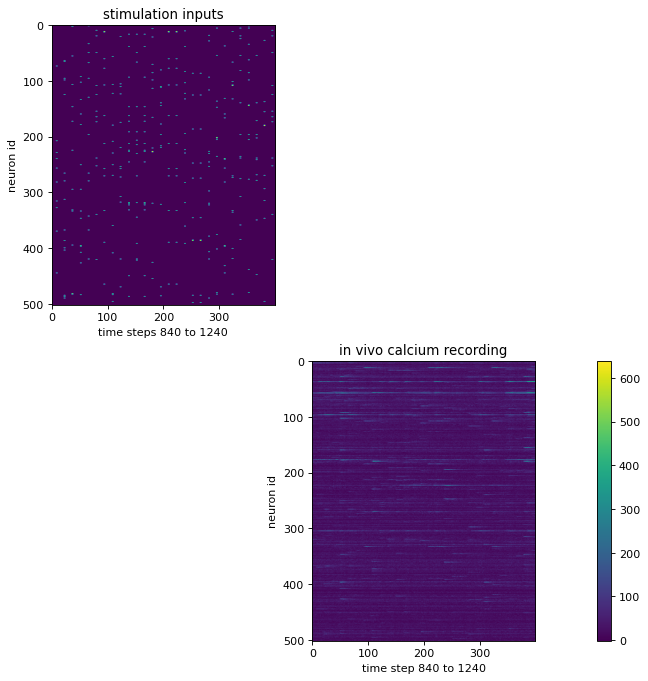

In [14]:
# nan represent removed interpolated steps in y
fig, axes = plt.subplots(2, 1, figsize=(20,10), dpi=80) #fig stores the whole figure, axes stores the individual plots
time_wind_start = 840
time_wind_end = 1240
neuron_start = 0
neuron_end = 1000

axes[0].imshow(u_session[time_wind_start: time_wind_end, neuron_start:neuron_end].T)
axes[0].set_title('stimulation inputs')
axes[0].set_xlabel('time steps 840 to 1240')
axes[0].set_ylabel('neuron id')

im = axes[1].imshow(y_session[time_wind_start: time_wind_end, neuron_start:neuron_end].T)
fig.colorbar(im)
axes[1].set_title('in vivo calcium recording')
axes[1].set_xlabel('time step 840 to 1240')
axes[1].set_ylabel('neuron id')
fig.savefig('photo_intro.pdf')

In [17]:
print(u_session[time_wind_start: time_wind_end, neuron_start:neuron_end].T.shape)
print(y_session[time_wind_start: time_wind_end].T.shape)

(502, 1000)
(502, 1000)


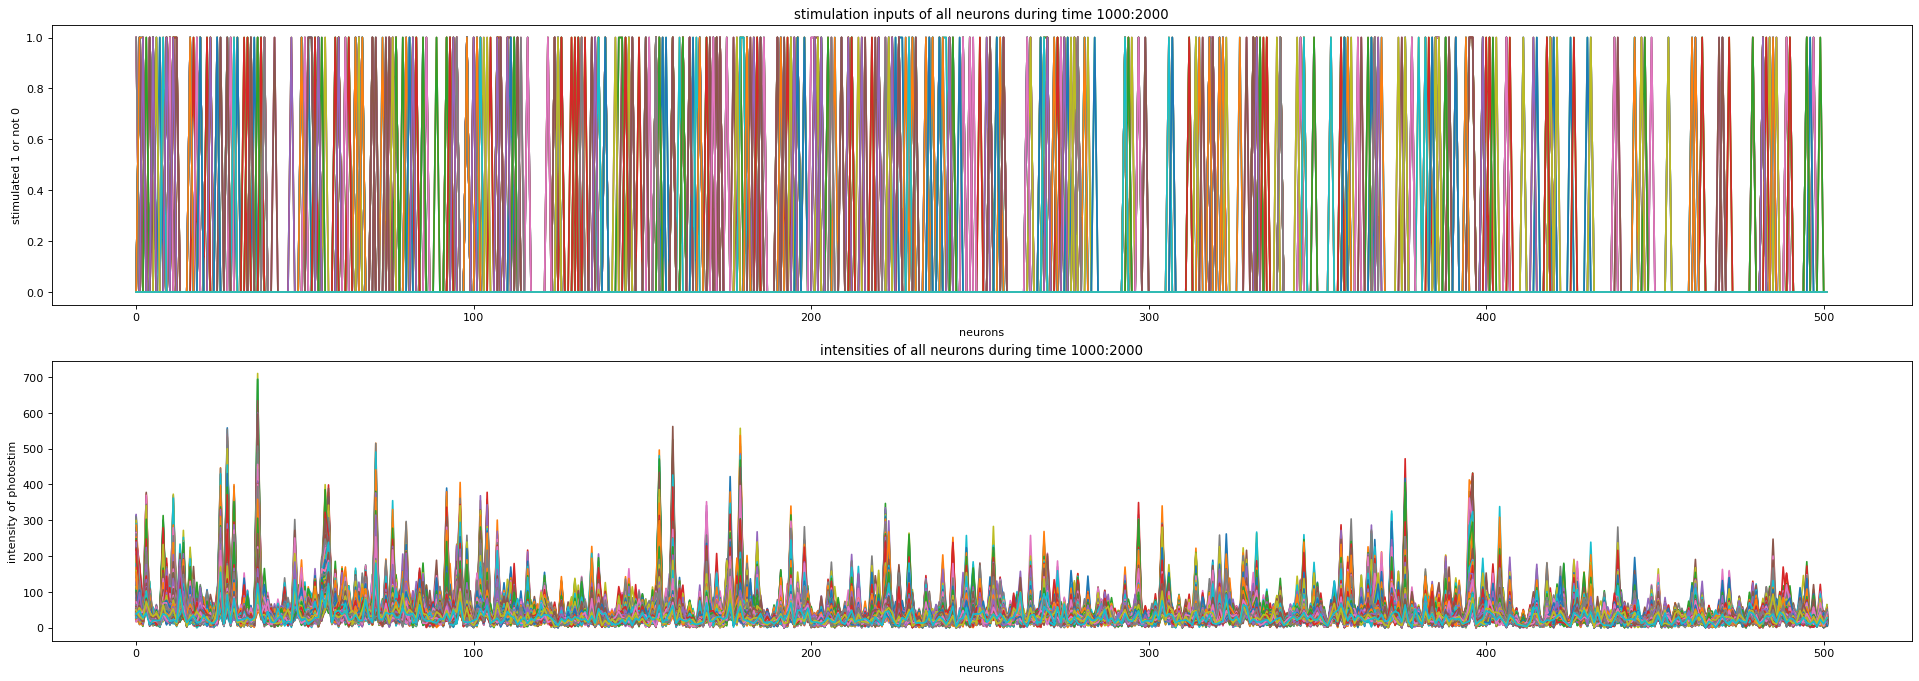

In [23]:
# nan represent removed interpolated steps in y
fig, axes = plt.subplots(2, 1, figsize=(30,10), dpi=80)
time_wind_start = 1000
time_wind_end = 2000
axes[0].plot(u_session[time_wind_start: time_wind_end].T)  #(502, 1000)
axes[0].set_title('stimulation inputs of all neurons during time 1000:2000')
axes[0].set_xlabel('neurons')
axes[0].set_ylabel('stimulated 1 or not 0')

axes[1].plot(y_session[time_wind_start: time_wind_end].T)  #(502, 1000)
axes[1].set_title('intensities of all neurons during time 1000:2000')
axes[1].set_xlabel('neurons')
axes[1].set_ylabel('intensity of photostim')
fig.savefig('photo_intro.pdf')